In [1]:
from torch_gan import Model
from torch_gan.generators import DCGANGenerator
from torch_gan.discriminators import DCGANDiscriminator
from torch_gan.generators import CGANGenerator
from torch_gan.discriminators import CGANDiscriminator
from torch_gan.generators import P2PGenerator
from torch_gan.discriminators import P2PDiscriminator
from torch_gan.discriminators import InfoGANDiscriminator
from torch_gan.discriminators import BEGANDiscriminator
from torch_gan.generators import SAGANGenerator
from torch_gan.discriminators import SAGANDiscriminator
from torch_gan.generators import ProGANGenerator
from torch_gan.discriminators import ProGANDiscriminator

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size = 32
latent_dim = 128

In [4]:
############DATASET############

In [7]:
dataset = datasets.MNIST(
    root = './data_MNIST',
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]),
    download=True,
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

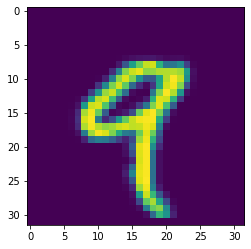

In [6]:
plt.imshow(dataset[4][0].squeeze())

In [7]:
loaders = {
    "train": DataLoader(dataset, batch_size=64, shuffle=True)
}

In [8]:
generator = ProGANGenerator(128, 32, 1).to(device)
discriminator = ProGANDiscriminator(32, 1).to(device)

model = {"generator": generator, "discriminator": discriminator}

In [9]:
optimizer = {
    "generator": torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.1, 0.9)),
    "discriminator": torch.optim.Adam(discriminator.parameters(), lr=0.0004, betas=(0.1, 0.9)),
}

In [ ]:
###########TRAINING###########

In [10]:
!pip3 install catalyst==20.10

     |████████████████████████████████| 1.0 MB 1.1 MB/s eta 0:00:01


In [11]:
from catalyst import dl

In [12]:
class CustomRunner(dl.Runner):
    fixed_z = torch.randn(4, latent_dim, device = device)

    def predict_fixed_z(self):
        generated_images = self.model["generator"](self.fixed_z, 32, 1)
        return generated_images

    def _handle_batch(self, batch):
        batch_metrics = {}
        
        real_images, _ = batch
        b_size = real_images.size(0)

        label_real = torch.full((b_size,), 0.0, dtype=torch.float, device=device)
        label_fake = torch.full((b_size,), 1.0, dtype=torch.float, device=device)

        ## Discriminator loss ##
        d_out_real  = self.model["discriminator"](real_images, 32, 1).view(-1)
        d_loss_real = self.criterion(d_out_real, label_real)

        z = torch.randn(b_size, latent_dim, device=self.device)
        fake_images = self.model["generator"](z, 32, 1).detach()
        d_out_fake  = self.model["discriminator"](fake_images, 32, 1)
        d_loss_fake = self.criterion(d_out_fake, label_fake)
        d_loss = d_loss_real + d_loss_fake

        if self.is_train_loader:
            self.optimizer['generator'].zero_grad()
            self.optimizer['discriminator'].zero_grad()
            d_loss.backward()
            self.optimizer['discriminator'].step()

        ## Generator loss ##
        z = torch.randn(b_size, latent_dim, device=self.device)
        fake_images = self.model["generator"](z, 32, 1)
        g_out_fake  = self.model["discriminator"](fake_images, 32, 1)
        g_loss      = self.criterion(g_out_fake, label_real)

        if self.is_train_loader:
            self.optimizer['generator'].zero_grad()
            self.optimizer['discriminator'].zero_grad()
            g_loss.backward()
            self.optimizer['generator'].step()

        batch_metrics["loss_discriminator"] = d_loss
        batch_metrics["loss_generator"]     = g_loss
        self.batch_metrics.update(**batch_metrics)

In [13]:
from catalyst.core import Callback, CallbackOrder

def plot_batch(batch):
    images = (batch.detach().cpu() + 1) / 2
    grid_img = torchvision.utils.make_grid(images)

    plt.figure(figsize=(12, 24))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

class LogFigureCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.External)

    def on_epoch_end(self, runner):
        generated_images = runner.predict_fixed_z()

        tb_callback = runner.callbacks["_tensorboard"]
        logger = tb_callback.loggers[runner.loader_name]
        logger.add_images(
            "image/epoch", 
            generated_images, 
            global_step=runner.epoch
        )
        plot_batch(generated_images)

In [14]:
logdir = "./logs_gan"

runner = CustomRunner(device = device)
runner.train(
    model      = model,
    criterion  = nn.BCELoss(),
    optimizer  = optimizer,
    loaders    = loaders,
    callbacks  = [
        LogFigureCallback(),
    ],
    main_metric = "loss_generator",
    logdir      = logdir,
    num_epochs  = 300,
    verbose     = True,
)

1/300 * Epoch (train):   0% 0/938 [00:00<?, ?it/s]

/home/aleksandr/.local/lib/python3.8/site-packages/catalyst/experiments/experiment.py:219: UserWarning:

Attention, there is only one dataloader - train

/home/aleksandr/.local/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/home/aleksandr/.local/lib/python3.8/site-packages/torch/nn/functional.py:3502: UserWarning:

The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 



Early exiting                                                                                              
1/300 * Epoch (train):   1% 12/938 [00:08<09:37,  1.60it/s, loss_discriminator=1.386, loss_generator=0.693]